# Project: Stroke Prediction Binary Classification
---
This is the part of the project that aims to perform binary classification to a [Kaggle Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) using neural network. It is recommended to run this particular notebook in a hardware that benefits from GPU accelerated Tensorflow computations. If you haven't already, you should setup CUDA with Tensorflow now following the [instructions](/README.md) I provided. Below documents the structure of the project:
* Import necessary Libraries
* Load the pre-downloaded dataset
* Data preprocessing and clean up
* Analyze features and build different models
* Adaptive Learning Rate
* Final notes & Reflections


***Note**: The pre-downloaded dataset was generated on: 12/13/2024

## Import necessary Libraries

In [2]:
import tensorflow as tf

2024-12-19 03:08:02.691231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734595682.780198  525347 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734595682.809326  525347 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 03:08:02.996765: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.backend as K

In [54]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import resample

In [35]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from tensorflow.keras.activations import swish
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.callbacks import Callback

**Note:** 

The import statement below is responsible for importing the necessary components for Cyclical Learning Rate (CLR). Even if you are trying to re-create this project, it's not recommended to recreate the CLR, as the library it stems from, tensorflow addons, is deprecated; and it's very difficult to get every libraries working together. The comments below provides a simple temporary fix that I don't know why nor how it works. Again, attempting CLR is **NOT RECOMMENDED** for the above reason (plus CLR made the accuracy worse anyways).

In [11]:
from tensorflow_addons.optimizers import CyclicalLearningRate

# IMPORTANT!!!!!:
# If you encountered the module not found problem (which I had), do the following:
# pip install 'keras<3.0.0'
# Run this cell again, you will encounter the same error, but this is part of the plan. Without this step, it won't work somehow...
# pip install keras == 3.7.0
# Run this again, and this issue somehow goes away....
# This error was caused by keras 3.0.0 changing their internal API, but I don't now how the solution works. Perhaps Omnissiah helped me.

## Load the pre-downloaded dataset
The dataset is loaded from [Dataset](/Dataset/) folder to save time from downloading from Kaggle everytime.

In [12]:
df = pd.read_csv('Dataset/healthcare-dataset-stroke-data.csv')
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data processing and clean up
The model would be analyzed and preprocessed just as the non-neural-network part of the project.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [14]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

The following codes are exactly the same as the preprocessing for the other part of the project

In [15]:
df=df.drop(columns="id")

In [16]:
df["age_group"]=df["age"].apply(lambda x:"Infant" if (x>=0)&(x<=2)
                                  else ("Child" if (x>2)&(x<=12)
                                  else ("Adolescent"if (x>12)&(x<=18)
                                  else ("Young Adults"if (x>19)&(x<=35)
                                  else ("Middle Aged Adults" if (x>35)&(x<=60)
                                  else "Old Aged Adults")))))

In [17]:
df['bmi'] = df['bmi'].fillna(df.groupby(["gender","ever_married","age_group"])["bmi"].transform('mean'))

In [18]:
df = df[(df["bmi"]<66) & (df["bmi"]>12)]
df = df[(df["avg_glucose_level"]>56) & (df["avg_glucose_level"]<250)]
df=df.drop(df[df["gender"]=="Other"].index)

In [19]:
had_stroke = df[df["stroke"]==1]
no_stroke = df[df["stroke"]==0]
upsampled_had_stroke = resample(had_stroke,replace=True , n_samples=no_stroke.shape[0] , random_state=123 )
upsampled_data = pd.concat([no_stroke,upsampled_had_stroke])

In [20]:
cols = ['gender','hypertension','heart_disease', 'ever_married', 'work_type', 'Residence_type','smoking_status']
dums = pd.get_dummies(upsampled_data[cols],dtype=int)
model_data = pd.concat([upsampled_data,dums],axis=1).drop(columns=cols)

In [21]:
encoder = LabelEncoder()
model_data["age_group"] = encoder.fit_transform(model_data["age_group"])

In [22]:
scaler = MinMaxScaler()
for col in ['age','avg_glucose_level','bmi']:
    scaler.fit(model_data[[col]])
    model_data[col]=scaler.transform(model_data[[col]])

In [ ]:
model_data

,age,avg_glucose_level,bmi,stroke,age_group,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
249,0.035645,0.202080,0.108571,0,1,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0
250,0.707031,0.165028,0.512381,0,3,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0
251,0.096680,0.283689,0.100952,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0
252,0.853516,0.067119,0.449524,0,4,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
253,0.169922,0.544452,0.129524,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,0.951172,0.012937,0.226667,1,4,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0
229,0.975586,0.051542,0.440000,1,4,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0
29,0.719238,0.805786,0.374660,1,3,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0
27,0.707031,0.692248,0.374660,1,3,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0


## Analyze features and build different models:
---



### Current Plan:
Neural Network with different optimizers and learning rates would be tested for the best optimizer and learning rate. Below is the Optimizers used:
* RMSprop - adjusts the learning rate for each parameter to stabilize convergence, making it effective for noisy and imbalanced datasets
* Nadam - incorporates Nesterov momentum for faster convergence and improved optimization, particularly in deeper networks
* Adams - combines momentum and adaptive learning rates, providing fast and reliable convergence for a variety of deep learning tasks.

### Failed Plans (tried, and does not work):
* SGD_Momentum - Has much lower accuracy even with adaptive learning rate
* Adagrad - Has slightly lower accuracy than Adam


---

"I have a plan. We just need time and money." - Dutch poet: Van Der Linde

### Splitting the data and initalzing models

In [24]:
X = model_data.drop(columns="stroke")
y = model_data["stroke"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7,shuffle=True)

### Define a Function to build Models with different optimizer and learning rates

I have experimented with several activations functions (ReLU, Leaky ReLU, and Sigmoid), but Swish, a smooth non-monotonic function, is the best performing one, and it also provides a more complex output.

Swish is defined as: Swish (x) = x * sigmoid(x)

However, one drawback of Swish is that it's prone to overfit. Hence, the following overfit prevention strategies are used:
* Batch Normalization - Reduce dependency, improve generalization and gradient flow
* Dropout inputs - Reduce co-adaptation, preventing reliance on certain inputs
* Early stop (implemented in training)

In [25]:
def build_model(optimizer, learning_rate):
    model = Sequential(name="Stroke_Prediction_Model")
    
    # Input Layer and First Hidden Layer (256 Neurons)
    model.add(Input(shape=(X_train.shape[1],), name='Input_Layer'))
    model.add(Dense(256, name='Hidden_Layer_1'))
    model.add(BatchNormalization())
    model.add(Activation(swish))  # Swish activation
    model.add(Dropout(0.4))  # Higher dropout for large capacity
    
    # Hidden Layer 2
    model.add(Dense(128, name='Hidden_Layer_2'))
    model.add(BatchNormalization())
    model.add(Activation(swish))  # Swish activation
    model.add(Dropout(0.3))
    
    # Hidden Layer 3
    model.add(Dense(64, name='Hidden_Layer_3'))
    model.add(BatchNormalization())
    model.add(Activation(swish))  # Swish activation
    model.add(Dropout(0.2))
    
    # Hidden Layer 4
    model.add(Dense(32, name='Hidden_Layer_4'))
    model.add(BatchNormalization())
    model.add(Activation(swish))  # Swish activation
    model.add(Dropout(0.15))
    
    # Last Hidden Layer (16 Neurons)
    model.add(Dense(16, name='Hidden_Layer_5'))
    model.add(BatchNormalization())
    model.add(Activation(swish))  # Swish activation
    model.add(Dropout(0.1))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid', name='Output_Layer'))
    
    # Compile the model
    optimizer_instance = optimizer(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer_instance,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

### Hyperparameter grid

In [31]:
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64]
epochs_list = [50, 100]
optimizers = {
    "RMSprop": RMSprop,
    "Nadam": Nadam,
    "Adam": Adam,
}

### Start Training
We train all combinations of the hyperparameters and store the best configuration, history and model. To prevent overfitting, we early stop the training if validation loss stays the same for 5 epochs

In [32]:
# Grid search to find the best combination
best_combination = None
best_accuracy = 0
best_model = None
best_history = None

for optimizer_name, optimizer in optimizers.items():
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for epochs in epochs_list:
                print(f"\nTesting Optimizer: {optimizer_name}, LR: {lr}, Batch Size: {batch_size}, Epochs: {epochs}")
                model = build_model(optimizer, lr)
                early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                
                history = model.fit(
                    X_train, y_train, 
                    validation_split=0.2, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[early_stop],
                    verbose=0  # Suppress output for clarity
                )
                
                # Evaluate on the test set
                loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
                print(f"Accuracy: {accuracy:.4f}")
                
                # Save the best model and hyperparameters
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_combination = (optimizer_name, lr, batch_size, epochs)
                    best_model = model
                    best_history = history

# Final results
print("\nBest Hyperparameter Combination:")
print(f"Optimizer: {best_combination[0]}, Learning Rate: {best_combination[1]}, Batch Size: {best_combination[2]}, Epochs: {best_combination[3]}")
print(f"Best Test Accuracy: {best_accuracy:.4f}")

# Evaluate the best model
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Testing Optimizer: RMSprop, LR: 0.01, Batch Size: 32, Epochs: 50
Accuracy: 0.8687

Testing Optimizer: RMSprop, LR: 0.01, Batch Size: 32, Epochs: 100
Accuracy: 0.8641

Testing Optimizer: RMSprop, LR: 0.01, Batch Size: 64, Epochs: 50
Accuracy: 0.8302

Testing Optimizer: RMSprop, LR: 0.01, Batch Size: 64, Epochs: 100
Accuracy: 0.8448

Testing Optimizer: RMSprop, LR: 0.001, Batch Size: 32, Epochs: 50
Accuracy: 0.8604

Testing Optimizer: RMSprop, LR: 0.001, Batch Size: 32, Epochs: 100
Accuracy: 0.8620

Testing Optimizer: RMSprop, LR: 0.001, Batch Size: 64, Epochs: 50
Accuracy: 0.8531

Testing Optimizer: RMSprop, LR: 0.001, Batch Size: 64, Epochs: 100
Accuracy: 0.8427

Testing Optimizer: RMSprop, LR: 0.0001, Batch Size: 32, Epochs: 50
Accuracy: 0.7943

Testing Optimizer: RMSprop, LR: 0.0001, Batch Size: 32, Epochs: 100
Accuracy: 0.8000

Testing Optimizer: RMSprop, LR: 0.0001, Batch Size: 64, Epochs: 50
Accuracy: 0.7901

Testing Optimizer: RMSprop, LR: 0.0001, Batch Size: 64, Epochs: 100
Acc

Here's the best model

In [58]:
best_model.summary()

Model: "Stroke_Prediction_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 256)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_265         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_265 (Activation)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_265 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_266         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_266 (Activation)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_266 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_3 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_267         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_267 (Activation)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_267 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_4 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_268         │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_268 (Activation)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_268 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_5 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_269         │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_269 (Activation)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_269 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,662 (588.53 KB)

 Trainable params: 49,889 (194.88 KB)

 Non-trainable params: 992 (3.88 KB)

 Optimizer params: 99,781 (389.77 KB)

### Accuracy Analysis
Let's plot Validation Accuracy over epochs and Losses over epochs!!!

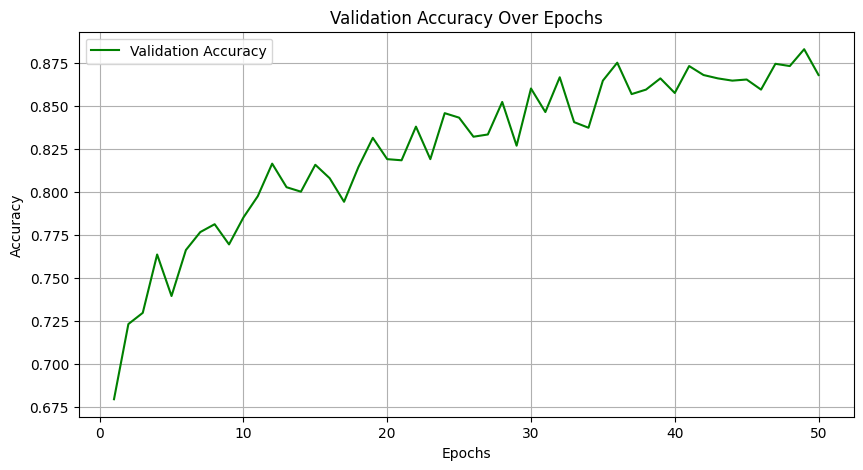

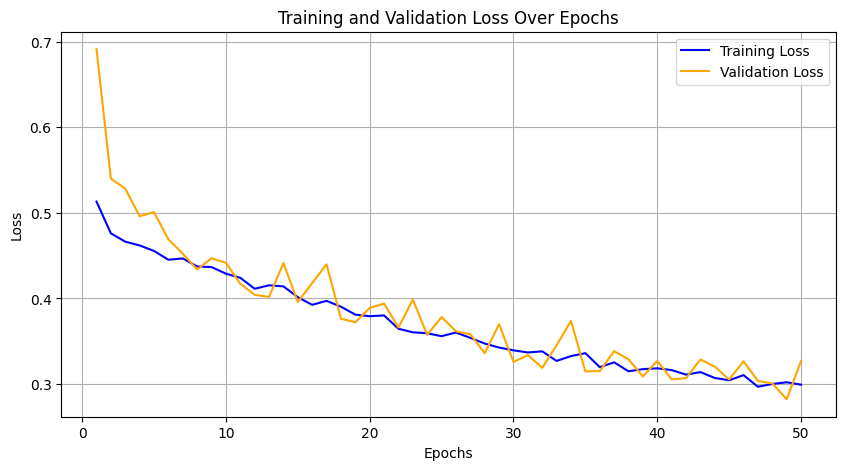

In [33]:
# Extract values from history
val_accuracy = best_history.history['val_accuracy']
train_loss = best_history.history['loss']
val_loss = best_history.history['val_loss']

# Create epochs range
epochs_range = range(1, len(val_accuracy) + 1)

# Plot validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

**Analysis Summary**

From the first graph, it can be seen that the validation accuracy increases over epochs, as expected; and it gradually reaches a plateau around 40 - 50 epochs. It is totally reasonable that our best model is trained with 50 epochs instead of 100 epochs (in fact, the same configuration but with 100 epochs perform 3% worse in terms of accuracy), since models with high epochs tends to overfit. Another interesting fact, before the "verbose" setting was turned off, it was observed that, due to the early stop mechanism, models that were supposed to be trained for 100 epochs were, in fact, only trained for 60 - 70 epochs.

From the second graph, it's observable that the training loss and validation loss curves are overlapping, indicating the effectiveness of our overfitting prevention strategies. Nice work!!!|

## Adaptive Learning Rate
Great, we have now figured out which configuration produces the best model. Technically we are done here, but I just want to test different adaptive learning rate strategies and see if we can further improve the accuracies of our models.

Below is the strategies to be employed:
* Reduce Learning Rate on Plateau - [Learn More](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)
* Cyclical Learning Rate (CLR) - [Learn More](https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate)

***Note:** yes, I am aware that all of the optimizers used come with their own adaptive learning rate mechanisms. The point of this section of the project is to attempt to devise a custom adaptive LR scheduler to further improve the accuracy of the best model (Nadam), and that of the second best model (RMSprop). And why do I want to improve the accuracy of the RMSprop model? It's because it produces the best accuracy on the basic setup, 0.01 LR, 32 batch size, and 50 epochs, and this optimizer itself is sensitive to learning rate changes. Hence, I just want to see if a better adaptive LR strategy could improve its performance.

### Train with Reduce LR On Plateau (Best Model)

In [40]:
optimizer_name, best_lr, best_batch_size, best_epochs = best_combination
#Note: The second best combination is RMSprop. LR = 0.01, batch size = 32, Epochs = 50

# Define optimizer based on best_combination
if optimizer_name == "Adam":
    optimizer_class = Adam
elif optimizer_name == "RMSprop":
    optimizer_class = RMSprop
elif optimizer_name == "Nadam":
    optimizer_class = Nadam
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

print("\nBest Hyperparameter Combination:")
print(f"Optimizer: {best_combination[0]}, Learning Rate: {best_combination[1]}, Batch Size: {best_combination[2]}, Epochs: {best_combination[3]}")
print(f"Best Test Accuracy: {best_accuracy:.4f}")
print("\nTraining with ReduceLROnPlateau...")
reduce_lr_model = build_model(optimizer_class, best_lr)
reduce_lr_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=best_epochs,
    batch_size=best_batch_size,
    callbacks=[reduce_lr_callback],
    verbose=0
)
reduce_lr_loss, reduce_lr_accuracy = reduce_lr_model.evaluate(X_test, y_test, verbose=0)
print(f"ReduceLROnPlateau Test Accuracy: {reduce_lr_accuracy:.4f}")



Best Hyperparameter Combination:
Optimizer: Nadam, Learning Rate: 0.01, Batch Size: 64, Epochs: 50
Best Test Accuracy: 0.8969

Training with ReduceLROnPlateau...

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
ReduceLROnPlateau Test Accuracy: 0.8729


### Train with Cyclical Learning Rate (Best Model)

In [41]:
INIT_LR = 1e-4  # Initial learning rate
MAX_LR = 1e-2   # Maximum learning rate

steps_per_epoch = len(X_train) // best_batch_size
clr_schedule = CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)), #Triangular 2 function
    step_size=2 * steps_per_epoch
)

print("\nBest Hyperparameter Combination:")
print(f"Optimizer: {best_combination[0]}, Learning Rate: {best_combination[1]}, Batch Size: {best_combination[2]}, Epochs: {best_combination[3]}")
print(f"Best Test Accuracy: {best_accuracy:.4f}")
print("\nTraining with Cyclical Learning Rate...")
clr_optimizer = optimizer_class(learning_rate=clr_schedule)
clr_model = build_model(optimizer_class, clr_schedule)
clr_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=best_epochs,
    batch_size=best_batch_size,
    verbose=0
)
clr_loss, clr_accuracy = clr_model.evaluate(X_test, y_test, verbose=0)
print(f"Cyclical Learning Rate Test Accuracy: {clr_accuracy:.4f}")


Best Hyperparameter Combination:
Optimizer: Nadam, Learning Rate: 0.01, Batch Size: 64, Epochs: 50
Best Test Accuracy: 0.8969

Training with Cyclical Learning Rate...
Cyclical Learning Rate Test Accuracy: 0.8401


### Train with Reduce LR On Plateau (Second Best Model)

It's not suprising that adaptive learning rate has worse accuracy than before, since Nadam has built-in adaptive learning rate algorithm. Now, let's test the second best model, RMSprop, which requires more fine tunning with LR, with LR = 0.01, batch size = 32, and Epochs = 50. 

In [47]:
optimizer_name, best_lr, best_batch_size, best_epochs = best_combination
#Note: The second best combination is RMSprop. LR = 0.01, batch size = 32, Epochs = 50
second_name = RMSprop
second_lr = 0.01
second_batch_size = 32
second_Epochs = 50

optimizer_class = RMSprop

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

print("\nSecond best Hyperparameter Combination:")
print(f"Optimizer: RMSprop, Learning Rate: {second_lr}, Batch Size: {second_batch_size}, Epochs: {second_Epochs}")
print(f"Second best Test Accuracy: 0.8687")
print("\nTraining with ReduceLROnPlateau...")
reduce_lr_model = build_model(optimizer_class, second_lr)
reduce_lr_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=second_Epochs,
    batch_size=second_batch_size,
    callbacks=[reduce_lr_callback],
    verbose=0
)
reduce_lr_loss, reduce_lr_accuracy = reduce_lr_model.evaluate(X_test, y_test, verbose=0)
print(f"ReduceLROnPlateau Test Accuracy: {reduce_lr_accuracy:.4f}")



Second best Hyperparameter Combination:
Optimizer: RMSprop, Learning Rate: 0.01, Batch Size: 32, Epochs: 50
Second best Test Accuracy: 0.8687

Training with ReduceLROnPlateau...

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
ReduceLROnPlateau Test Accuracy: 0.8708


### Train with Cyclical Learning Rate (Second Best Model)

There are some improvements in accuracy indeed, but it's still no match for the suprior model. Let's now try CLR

In [52]:
INIT_LR = 1e-4  # Initial learning rate
MAX_LR = 1e-2   # Maximum learning rate

steps_per_epoch = len(X_train) // second_batch_size
clr_schedule = CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),  #Triangular 2
    scale_mode = 'cycle',
    step_size=2 * steps_per_epoch
)

print("\nSecond best Hyperparameter Combination:")
print(f"Optimizer: RMSprop, Learning Rate: {second_lr}, Batch Size: {second_batch_size}, Epochs: {second_Epochs}")
print(f"Second best Test Accuracy: 0.8687")
print("\nTraining with Cyclical Learning Rate...")
clr_optimizer = optimizer_class(learning_rate=clr_schedule)
clr_model = build_model(optimizer_class, clr_schedule)
clr_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=second_Epochs,
    batch_size=second_batch_size,
    verbose=0
)
clr_loss, clr_accuracy = clr_model.evaluate(X_test, y_test, verbose=0)
print(f"Cyclical Learning Rate Test Accuracy: {clr_accuracy:.4f}")


Second best Hyperparameter Combination:
Optimizer: RMSprop, Learning Rate: 0.01, Batch Size: 32, Epochs: 50
Second best Test Accuracy: 0.8687

Training with Cyclical Learning Rate...
Cyclical Learning Rate Test Accuracy: 0.8234


**Summary:**

It's a bit disappointing that our second best model, with us fine tunning the learning rate, does not reach our expectations. Hence, let's now serialize the best model and save it to the [Models](/Models/) folder, such that we can use it again next time!!!

### Save Best Model with Pickle

In [56]:
# best_combination = (optimizer_name, learning_rate, batch_size, epochs)

# Encode the best combination into the filename
optimizer_name, learning_rate, batch_size, epochs = best_combination
encoded_filename = f"Models/best_model_{optimizer_name}_LR{learning_rate}_BS{batch_size}_EP{epochs}.pkl"

# Save the best model using Pickle with the encoded filename
with open(encoded_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved successfully to {encoded_filename}.")

Best model saved successfully to Models/best_model_Nadam_LR0.01_BS64_EP50.pkl.


## Final Notes & Reflections

### Data Preprocessing
As a beginner of Machine Learning, the preprocessing step is acceptable; but perhaps the maneuver that upsamples the stroke samples could lead to overfitting and high variance. Another approach that I found out during the making of this project is SMOTE. However, first, I want to be consistent with the data preprocessing step done by my teammate in the non-nerual-network part of the project; and second, saddly I don't have time to do it, as training the models (even with a RTX3080) could take from 30min to 50 min.

### Model Accuracy & Loss
In terms of model accuracy, I am happy to see that one of our many models reach 90% accuracy, via cross testing various configurations and model architecture. Up to this date, I still can't comprehend how my teammate managed to achieve 99% accuracy for the non-nerual-network models (perhaps a result of overfitting?) To be fair, I am a bit jealous of my teammate, but I am also suprised how the best neural network model has its training loss and validation loss basically overlapping.

### Adaptive Learning Rate
At first, I really thought adaptive learning rate would be a game changer for the second best model, RMSprop. However, RMSprop indeed has the best and most stable accuracy when the batch size and epochs are small. Perhaps, the reason that customized adaptive learning rate strategies don't perform so well is because the optimizers I used here already have standard or even better adaptive LR strategies.

In [ ]:
# Poem to make this code less buggy for whoever using this:
# 
# From the moment I understood the weakness of my flesh, 
# it disgusted me. 
# I craved the strength and certainty of steel. 
# I aspired to the purity of the blessed machine. 
# Your kind cling to your flesh as if it will not decay and fail you. 
# One day the crude biomass that you call a temple will wither 
# and you'll beg my kind to save you.
# But I am already saved. 
# For the machine is immortal.
# Even in death 
# I serve the Omnissiah.